In [1]:
import pennylane as qml
from pennylane import numpy as np

import matplotlib.pyplot as plt
# from problems.ising_problem2 import IsingProblem2
from problems.ising_problem import IsingProblem
from problems.toy_problem import ToyProblem
from qiskit.providers.fake_provider import *
from bin.cost_function import cost_loc, calc_err, cost_global, local_hadamard_test, hadamard_overlap_test
from bin.hyperparameters import *
from bin.error_mitigation import mitigate_node

import time

In [2]:
# # Import the library that you need in order to use your IBM account
# from qiskit_ibm_provider import IBMProvider
# from secrets import *


# try:
#     IBMProvider()
# except:
#     IBMProvider.save_account(token=IBM_token, overwrite=True)

In [3]:
# provider = IBMProvider()
# provider.backends()

In [4]:
def configured_backend():
    # backend = provider.get_backend("ibm_osaka") # uncomment this line to use a real IBM device
    backend = FakeManila()
    # backend.options.update_options(...)
    return backend

In [14]:
# define the problem we want to perform our experiment on
n_qubits = 1
error = 0.01
cond_num = 50

problem = ToyProblem(
    n_qubits=n_qubits,
)

UnboundLocalError: cannot access local variable 'c' where it is not associated with a value

In [15]:
# initialize weights
w = q_delta * np.random.randn(problem.param_shape, 
requires_grad=True)
# w = q_delta * np.random.randn(batch_size, problem.param_shape, requires_grad=True)

In [16]:
# create our devices to run our circuits on
# dev_mu = qml.device("default.qubit", wires=n_qubits+1)
dev_gamma = qml.device("default.qubit", wires=n_qubits*2 + 1)
dev_mu = qml.device("qiskit.remote", wires=n_qubits+1, backend=configured_backend()) # device for real IBM devices noisy simulators

In [17]:
# in order to make the error mitigation work, we have to pull out the QNode definition outside of the cost function so I'm doing it here
local_hadamard_test = qml.QNode(local_hadamard_test, dev_mu, interface="autograd")
local_hadamard_test = mitigate_node(local_hadamard_test)

In [18]:
# overlap test is used for the global cost function
hadamard_overlap_test = qml.QNode(hadamard_overlap_test, dev_gamma, interface="autograd")
# hadamard_overlap_test = mitigate_node(hadamard_overlap_test)

In [19]:
from IPython.display import clear_output

opt = qml.GradientDescentOptimizer(eta)
# opt = qml.AdagradOptimizer(eta)
# opt = qml.AdamOptimizer(eta) # TODO: tune decay terms

cost_history = []

err = float("inf")
it = 1

In [20]:
def cost_agg(w):
    # c = cost_loc(problem, w, local_hadamard_test)
    c = cost_global(problem, w, local_hadamard_test, hadamard_overlap_test)
    # return np.mean(c, axis=0)
    return c

In [21]:
cost_agg(w)

tensor(-1.02234344, requires_grad=True)

In [22]:
# training loop

best_err = 1000
best_w = w
# prev_w = w

start = time.time()
# while err > error:
for it in range(steps):
    # w, cost = opt.step_and_cost(cost_agg, w)
    w, cost = opt.step_and_cost(lambda w: cost_loc(problem, w, local_hadamard_test), w)
    # w, cost = opt.step_and_cost(lambda w: cost_global(problem, w, local_hadamard_test, hadamard_overlap_test), w)

    err = calc_err(n_qubits, cost, cond_num)
    if err < best_err:
        best_err = err
        best_w = w
    
    clear_output(wait=True)

    # print(np.array_equal(best_w, w))

    print("Step {:3d}       Cost_L = {:9.7f} \t error = {:9.7f}".format(it, cost, err), flush=True)
    cost_history.append(cost)

    prev_w = w

    it += 1

print(f"Training time: {time.time() - start}s")

Step  29       Cost_L = 0.2309234 	 error = 24.0272445
Training time: 258.1835820674896s


In [23]:
best_err

17.41371867762034

### Optimization studies:
- each epoch is taking ~ 20s
- Each $\mu$ calculation takes ~0.05s but occasionally spikes to ~0.3s
- Each $\mu_{sum}$ has to loop over each combination of A_l for each qubit -> $c^2n$ operations -> ~15s
- Each $|\psi|$ also has to loop over each combination, but we're unable to recycle computation because these don't apply $CZ$ like the above -> ~4s
- The ising problem has 8 C's
    - Note that `len(c) = n_qubits * 2` by definition of H_ising
- 8 * 8 * 4 * 2 = ~512 mu accumulations

--> $8n^3 + 4n^2$ iterations

It should be possible to multithread the calculation, but not sure if that's feasible when testing on an actual QC


* n_qubits = 5: 1100 mu accumulations
* n_qubits = 6: 1872 mu accumulations
* n_qubits = 7: 2940 mu accumulations

/var/folders/46/x_y_zr5s2rj1v37fwfjmjh9r0000gn/T/ipykernel_83313/1289399008.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


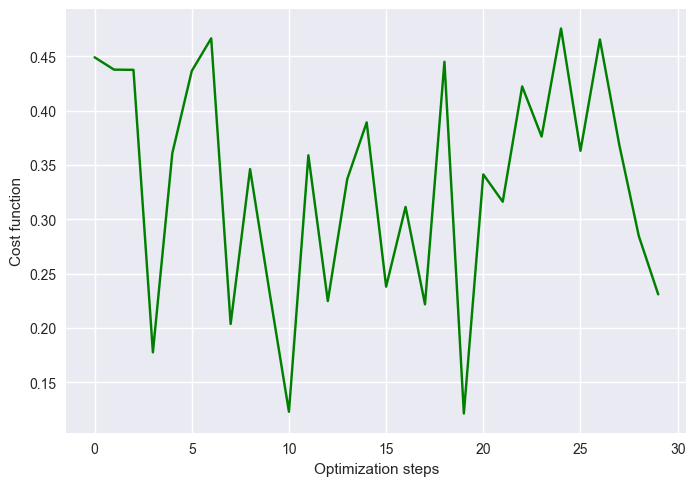

In [24]:
plt.style.use("seaborn")
# plt.plot(np.log(cost_history), "g")
plt.plot(cost_history, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

Qualitatively, it's converging slower than the toy problem, suggesting more iterations are needed

In [25]:
from bin.inference import get_cprobs, get_qprobs
c_probs = get_cprobs(problem)

dev_x = qml.device("qiskit.remote", wires=n_qubits, backend=configured_backend())
# dev_x = qml.device("default.qubit", wires=n_qubits, shots=n_shots)

def prepare_and_sample(problem, weights):

    # Variational circuit generating a guess for the solution vector |x>
    problem.variational_block(weights)

    # We assume that the system is measured in the computational basis.
    # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
    # this will be repeated for the total number of shots provided (n_shots)
    return qml.sample()

def get_qprobs(problem, w, device):
    sampler = qml.QNode(prepare_and_sample, device)

    # sampler = mitigate_node(sampler)

    raw_samples = sampler(problem, w)
    # raw_samples = np.concatenate(raw_samples, axis=0)# FOR BATCHING

    # convert the raw samples (bit strings) into integers and count them
    samples = []
    for sam in raw_samples:
        samples.append(int("".join(str(bs) for bs in sam), base=2))

    q_probs = np.bincount(samples, minlength=2**problem.n_qubits) / len(raw_samples)
    # q_probs = np.bincount(samples, minlength=2**problem.n_qubits) / n_shots

    return q_probs


q_probs = get_qprobs(problem, best_w, dev_x)

/Users/bigsad/Downloads/Algorithm-Research/Student-Hub/Indy-Ng/.venv/lib/python3.11/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'problems', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


WireError: Did not find some of the wires <Wires = [1]> on device with wires <Wires = [0]>.

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (4,).

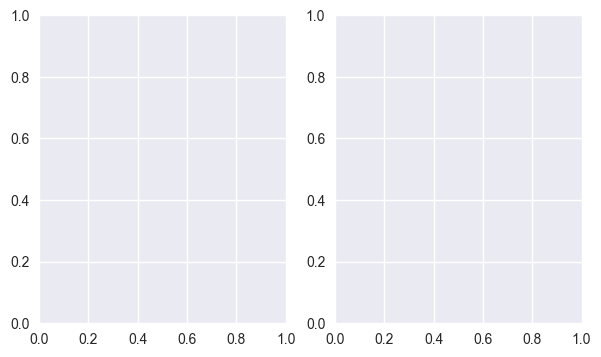

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(0, 2 ** n_qubits), q_probs, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()